# Single-cell analysis of the murine tendon enthesis: focus on the mesenchymal compartment

## Background
The enthesis is the specialized tissue at the interface between tendon/ligament and bone and is increasingly recognized as a key site in the pathophysiology of spondyloarthritis (SpA). Inflammation at the enthesis is thought to arise from interactions between biomechanical stress, stromal (mesenchymal) cells, and immune cells. Understanding the cellular composition and developmental dynamics of the enthesis is therefore relevant for translational immunology and tissue biology.

In this notebook, I analyze single-cell RNA sequencing (scRNA-seq) data from a published mouse study investigating immune–mesenchymal crosstalk during postnatal enthesis development.

## Data source
The data originate from the study:

**Leifer et al., Scientific Reports (2024)**  
*“Single-cell RNA-sequencing analysis of immune and mesenchymal cell crosstalk in the developing enthesis”*

The authors profiled the murine supraspinatus tendon enthesis at three postnatal timepoints:
- **P11** (pre-mineralization)
- **P18** (during mineralization)
- **P56** (post-mineralization)

Single-cell RNA-seq data were deposited in the Gene Expression Omnibus (GEO) under accession **GSE182997**.

## Analysis objectives
The goal of this analysis is to perform a focused investigation of the **mesenchymal cell compartment** across developmental timepoints. Specifically, we aim to:

1. Load and preprocess scRNA-seq data from all three timepoints.
2. Perform quality control, normalization, and identification of highly variable genes.
3. Integrate cells across developmental timepoints to reduce timepoint-driven effects while preserving biological structure.
4. Identify and subset **mesenchymal cells** based on clustering and canonical marker genes.
5. Visualize the mesenchymal compartment using UMAP.
6. Examine the expression of **Cd200**:
   - As a feature plot on the mesenchymal UMAP.
   - Across developmental timepoints (P11 vs P18 vs P56).

This notebook documents the full analysis workflow and serves as a reproducible record of the computational steps used to address these questions.


In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import gzip
import scipy.sparse as sp
import scipy.io
from scipy.stats import median_abs_deviation


In [2]:
import os

In [3]:
# Setup
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, facecolor='white', figsize=(8, 6))


In [4]:
## Set base directory
data_dir = './GSE182997_RAW/'  

def load_10x_sample(gsm_id, timepoint, data_dir):
    """
    Load one 10X format sample
    """
    print(f"\nLoading {timepoint} ({gsm_id})...")
    
    if timepoint == 'P11':
        matrix_file = f'{gsm_id}_P11_matrix.mtx.gz'
        features_file = f'{gsm_id}_P11_features.tsv.gz'
        barcodes_file = f'{gsm_id}_P11_barcodes.tsv.gz'
    elif timepoint == 'P18':
        matrix_file = f'{gsm_id}_P18_matrix.mtx.gz'
        features_file = f'{gsm_id}_P18_features.tsv.gz'
        barcodes_file = f'{gsm_id}_P18_barcodes.tsv.gz'
    elif timepoint == 'P56':
        matrix_file = f'{gsm_id}_P56_matrix.mtx.gz'
        features_file = f'{gsm_id}_P56_features.tsv.gz'
        barcodes_file = f'{gsm_id}_P56_barcodes.tsv.gz'
    
    matrix_path = os.path.join(data_dir, matrix_file)
    features_path = os.path.join(data_dir, features_file)
    barcodes_path = os.path.join(data_dir, barcodes_file)
    
    # Check files exist
    for filepath, name in [(matrix_path, 'matrix'), (features_path, 'features'), (barcodes_path, 'barcodes')]:
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Cannot find {name} file: {filepath}")
    
    # Read matrix
    print(f"  Reading matrix...")
    with gzip.open(matrix_path, 'rt') as f:
        mat = scipy.io.mmread(f).T.tocsr()  # Transpose: cells x genes
    
    # Read features (genes)
    print(f"  Reading features...")
    features = pd.read_csv(features_path, sep='\t', header=None, compression='gzip')
    
    # Read barcodes (cells)
    print(f"  Reading barcodes...")
    barcodes = pd.read_csv(barcodes_path, sep='\t', header=None, compression='gzip')
    
    # Create AnnData object
    adata = sc.AnnData(X=mat)
    adata.obs_names = barcodes[0].values
    
    # Features: column 0 = gene IDs, column 1 = gene symbols (if 2 columns)
    if features.shape[1] >= 2:
        adata.var_names = features[1].values  # Gene symbols
        adata.var['gene_ids'] = features[0].values  # Gene IDs
    else:
        adata.var_names = features[0].values
    
    # Make unique
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    
    # Add metadata
    adata.obs['timepoint'] = timepoint
    adata.obs['gsm_id'] = gsm_id
    
    print(f"  ✓ {adata.n_obs} cells × {adata.n_vars} genes")
    
    return adata


In [5]:
samples = {
    'GSM5548416': 'P11',
    'GSM5548417': 'P18',
    'GSM5548418': 'P56',
}

adatas = []
for gsm, timepoint in samples.items():
    adata = load_10x_sample(gsm, timepoint, data_dir)
    adatas.append(adata)


Loading P11 (GSM5548416)...
  Reading matrix...
  Reading features...
  Reading barcodes...
  ✓ 3263 cells × 31053 genes

Loading P18 (GSM5548417)...
  Reading matrix...
  Reading features...
  Reading barcodes...
  ✓ 5588 cells × 31053 genes

Loading P56 (GSM5548418)...
  Reading matrix...
  Reading features...
  Reading barcodes...
  ✓ 5520 cells × 31053 genes


In [6]:
def preprocess_10x_data(adata):
    # Prep and take a look at QC metrics
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var['mt'] |= adata.var_names.str.startswith('MT-')

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
    
    print(f"\nQC statistics:")
    print(f"  Total UMI per cell (median): {adata.obs['total_counts'].median():.0f}")
    print(f"  Genes per cell (median): {adata.obs['n_genes_by_counts'].median():.0f}")
    print(f"  MT% per cell (median): {adata.obs['pct_counts_mt'].median():.2f}%")

    # Print Before
    print("\n" + "="*70)
    print("Filtering")
    print("="*70)
    print(f"Before: {adata.n_obs} cells")

    # Filter and print after
    #these thresholds are from the paper
    # 1. Remove genes expressed in < 2 cells
    sc.pp.filter_genes(adata, min_cells=2)
    # 2. Remove cells with < 200 genes detected
    sc.pp.filter_cells(adata, min_genes=200)
    # 3. Remove cells with < 1000 total UMIs (counts)
    sc.pp.filter_cells(adata, min_counts=1000)
    # 4. Remove cells with > 20% mitochondrial genes    
    adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
    print(f"After: {adata.n_obs} cells")
    # Normalize data
    sc.pp.normalize_total(adata, target_sum=1e4)
    print(adata.obs['timepoint'].value_counts())

    # Normalization
    print("\n" + "="*70)
    print("Normalization and preprocessing")
    print("="*70)

    # Normalize to 10,000 counts per cell
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log transform
    sc.pp.log1p(adata)
    return adata



In [7]:
adata_11 = preprocess_10x_data(adatas[0])
adata_18 = preprocess_10x_data(adatas[1])
adata_56 = preprocess_10x_data(adatas[2])

print(adata_11)
print(adata_18)
print(adata_56)


QC statistics:
  Total UMI per cell (median): 12848
  Genes per cell (median): 3096
  MT% per cell (median): 0.00%

Filtering
Before: 3263 cells
filtered out 12427 genes that are detected in less than 2 cells
filtered out 38 cells that have less than 200 genes expressed
filtered out 41 cells that have less than 1000 counts
After: 3184 cells
normalizing counts per cell
    finished (0:00:03)
timepoint
P11    3184
Name: count, dtype: int64

Normalization and preprocessing
normalizing counts per cell
    finished (0:00:00)

QC statistics:
  Total UMI per cell (median): 7226
  Genes per cell (median): 2064
  MT% per cell (median): 0.00%

Filtering
Before: 5588 cells
filtered out 12618 genes that are detected in less than 2 cells
filtered out 67 cells that have less than 200 genes expressed
filtered out 79 cells that have less than 1000 counts
After: 5442 cells
normalizing counts per cell
    finished (0:00:00)
timepoint
P18    5442
Name: count, dtype: int64

Normalization and preprocessin

In [8]:
# Now HVG and PCA we do on combined data
adata = sc.concat([adata_11, adata_18, adata_56], 
                  label='batch', keys=['P11', 'P18', 'P56'])
#Set HVG
sc.pp.highly_variable_genes(adata, n_top_genes=3000,
    flavor="seurat_v3" ,batch_key='timepoint')
#Keep raw
adata.raw = adata

#Set aside hvg and perform PCA
adata_hvg = adata[:, adata.var.highly_variable].copy()
adata_hvg.obs_names_make_unique()
sc.tl.pca(adata_hvg, n_comps=50, svd_solver="arpack")

extracting highly variable genes


/usr/local/Caskroom/mambaforge/base/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/1g/tyfpzm995b16hq8pjlm5m3700000gq/T/ipykernel_37599/679608999.py:5: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  sc.pp.highly_variable_genes(adata, n_top_genes=3000,


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA


/usr/local/Caskroom/mambaforge/base/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    with n_comps=50
    finished (0:00:03)


### Making two copies, one without and one with batch correction

In [9]:
adata_pre = adata_hvg.copy()
adata_post = adata_hvg.copy()


computing neighbors


/usr/local/Caskroom/mambaforge/base/envs/pipeline/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:59)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)
running Leiden clustering


/var/folders/1g/tyfpzm995b16hq8pjlm5m3700000gq/T/ipykernel_37599/2570406161.py:3: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata_pre, resolution=0.5, key_added="leiden_pre")


    finished: found 24 clusters and added
    'leiden_pre', the cluster labels (adata.obs, categorical) (0:00:01)


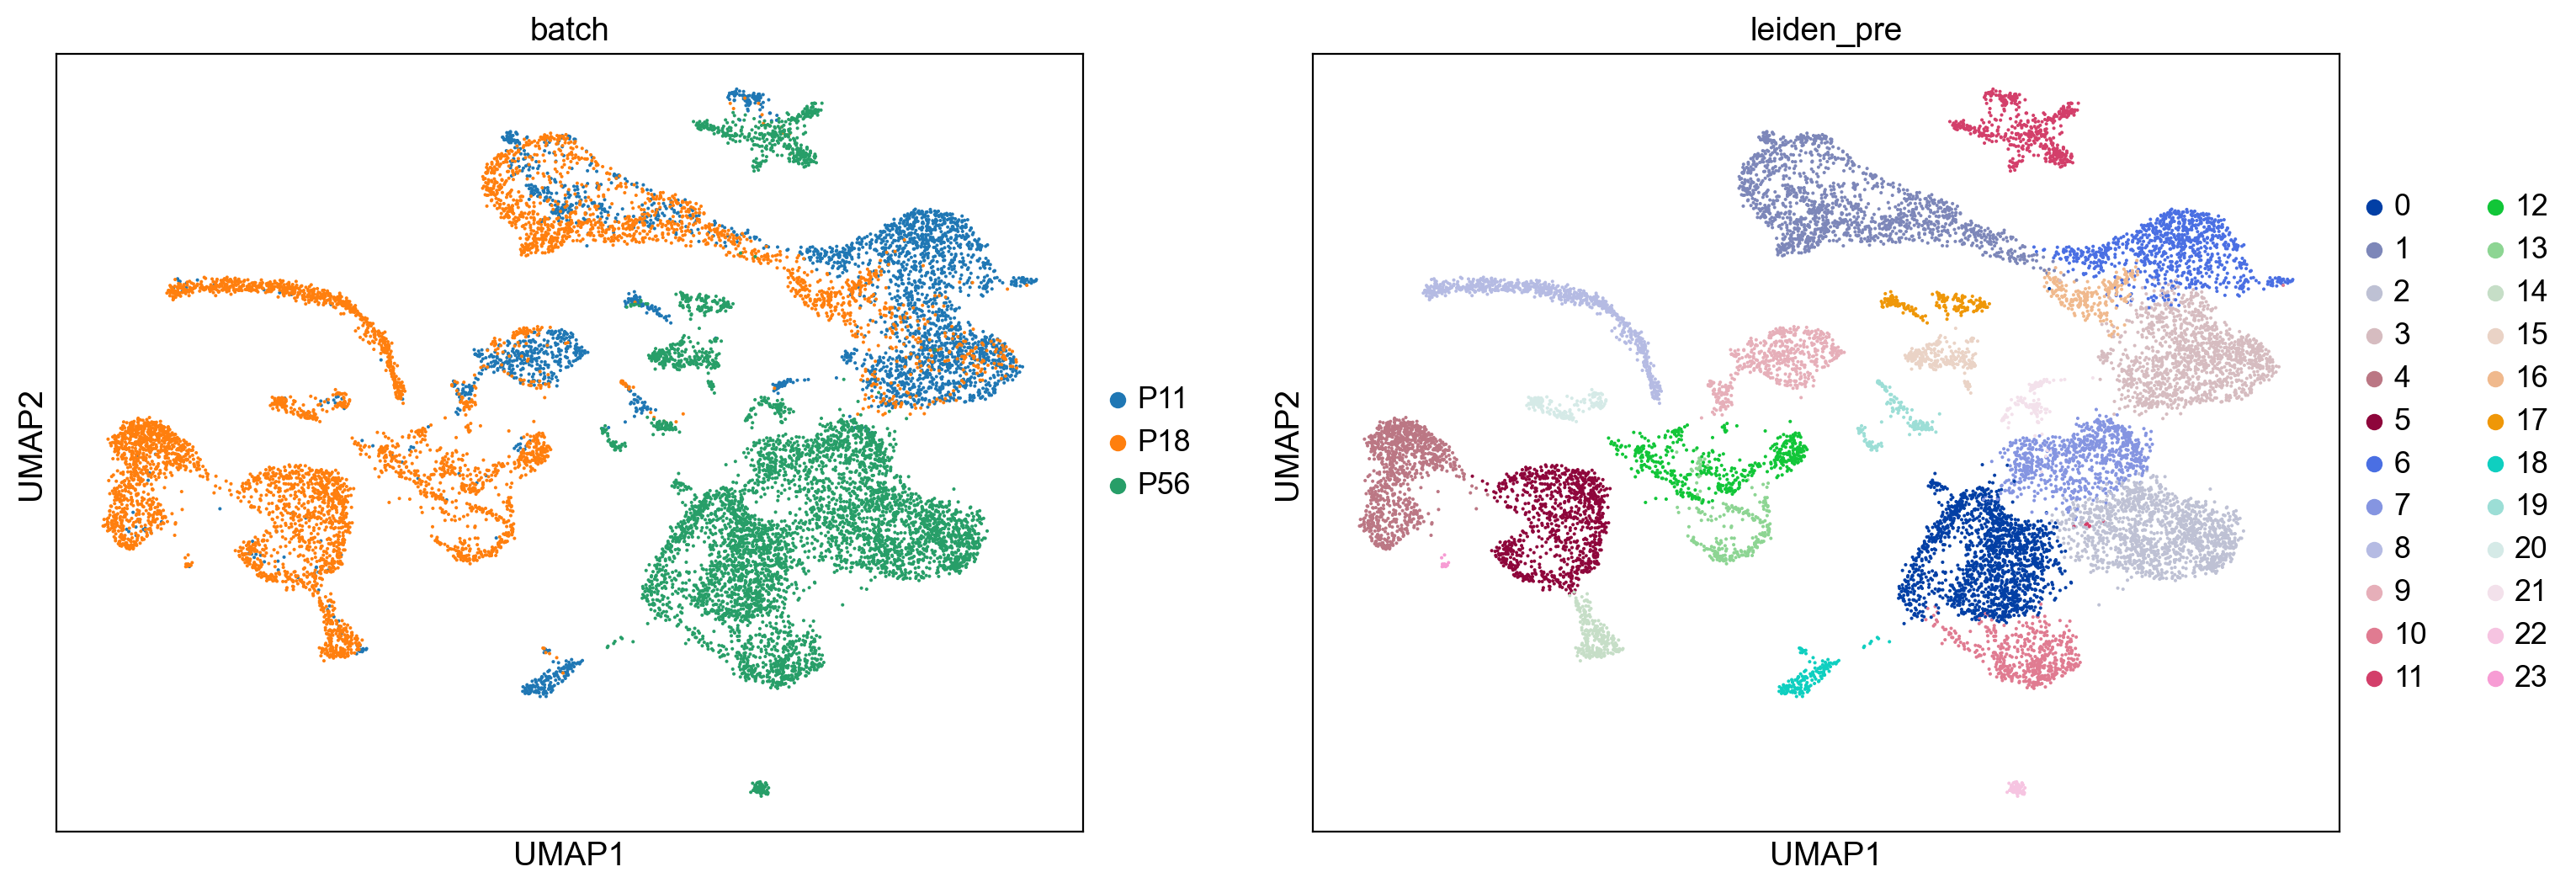

In [10]:
sc.pp.neighbors(adata_pre, use_rep="X_pca", n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_pre)
sc.tl.leiden(adata_pre, resolution=0.5, key_added="leiden_pre")

sc.pl.umap(adata_pre, color=["batch", "leiden_pre"])


Tried harmony, but environment breaks. Using bbknn instead

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
running Leiden clustering


/var/folders/1g/tyfpzm995b16hq8pjlm5m3700000gq/T/ipykernel_37599/2278180869.py:5: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata_post, resolution=0.5, key_added="leiden_post")


    finished: found 18 clusters and added
    'leiden_post', the cluster labels (adata.obs, categorical) (0:00:01)


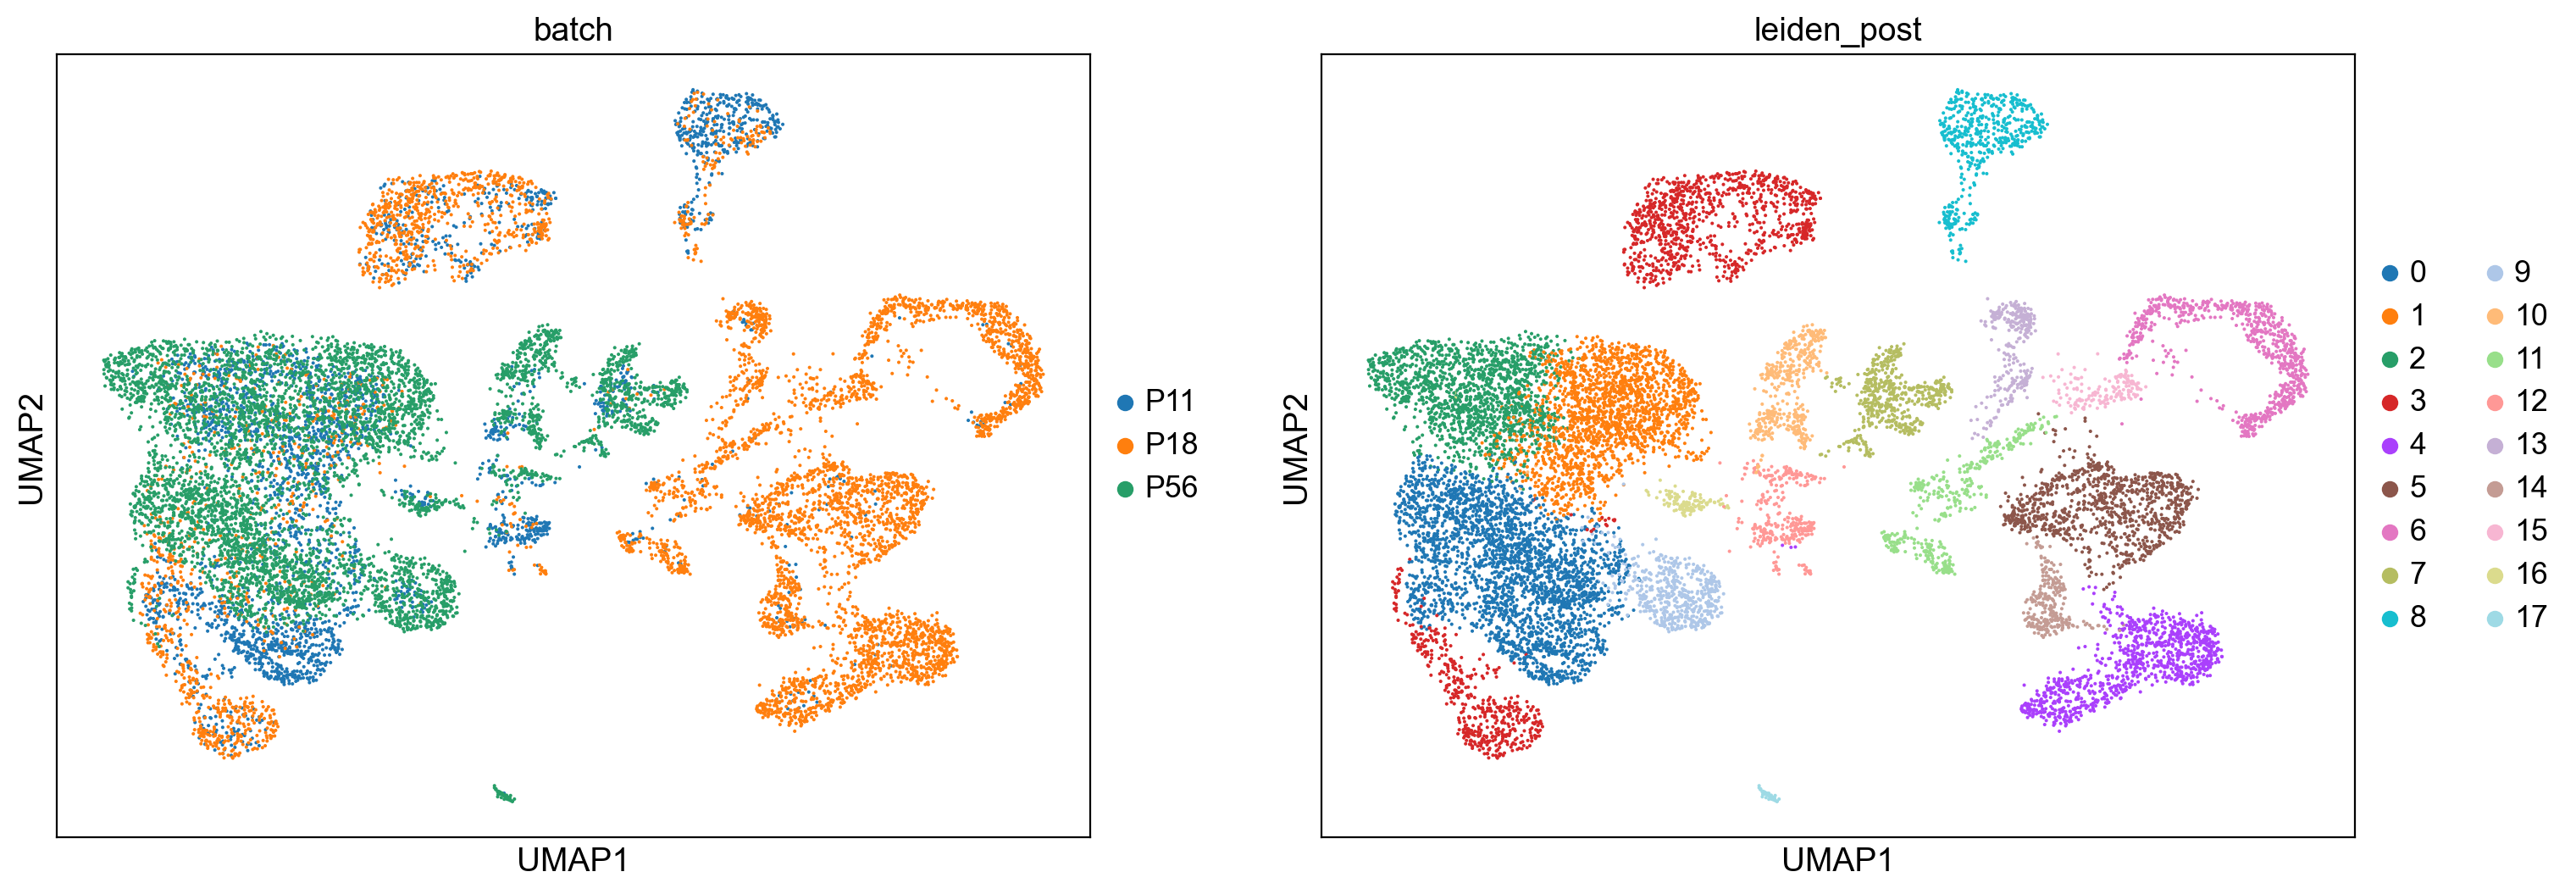

In [11]:
import bbknn

bbknn.bbknn(adata_post, batch_key="batch", n_pcs=50, neighbors_within_batch=5)
sc.tl.umap(adata_post)
sc.tl.leiden(adata_post, resolution=0.5, key_added="leiden_post")

sc.pl.umap(adata_post, color=["batch", "leiden_post"])


In [12]:
adata.obs["leiden_post"] = adata_post.obs.loc[adata.obs_names, "leiden_post"]
adata

AnnData object with n_obs × n_vars = 13982 × 16064
    obs: 'timepoint', 'gsm_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'batch', 'leiden_post'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'

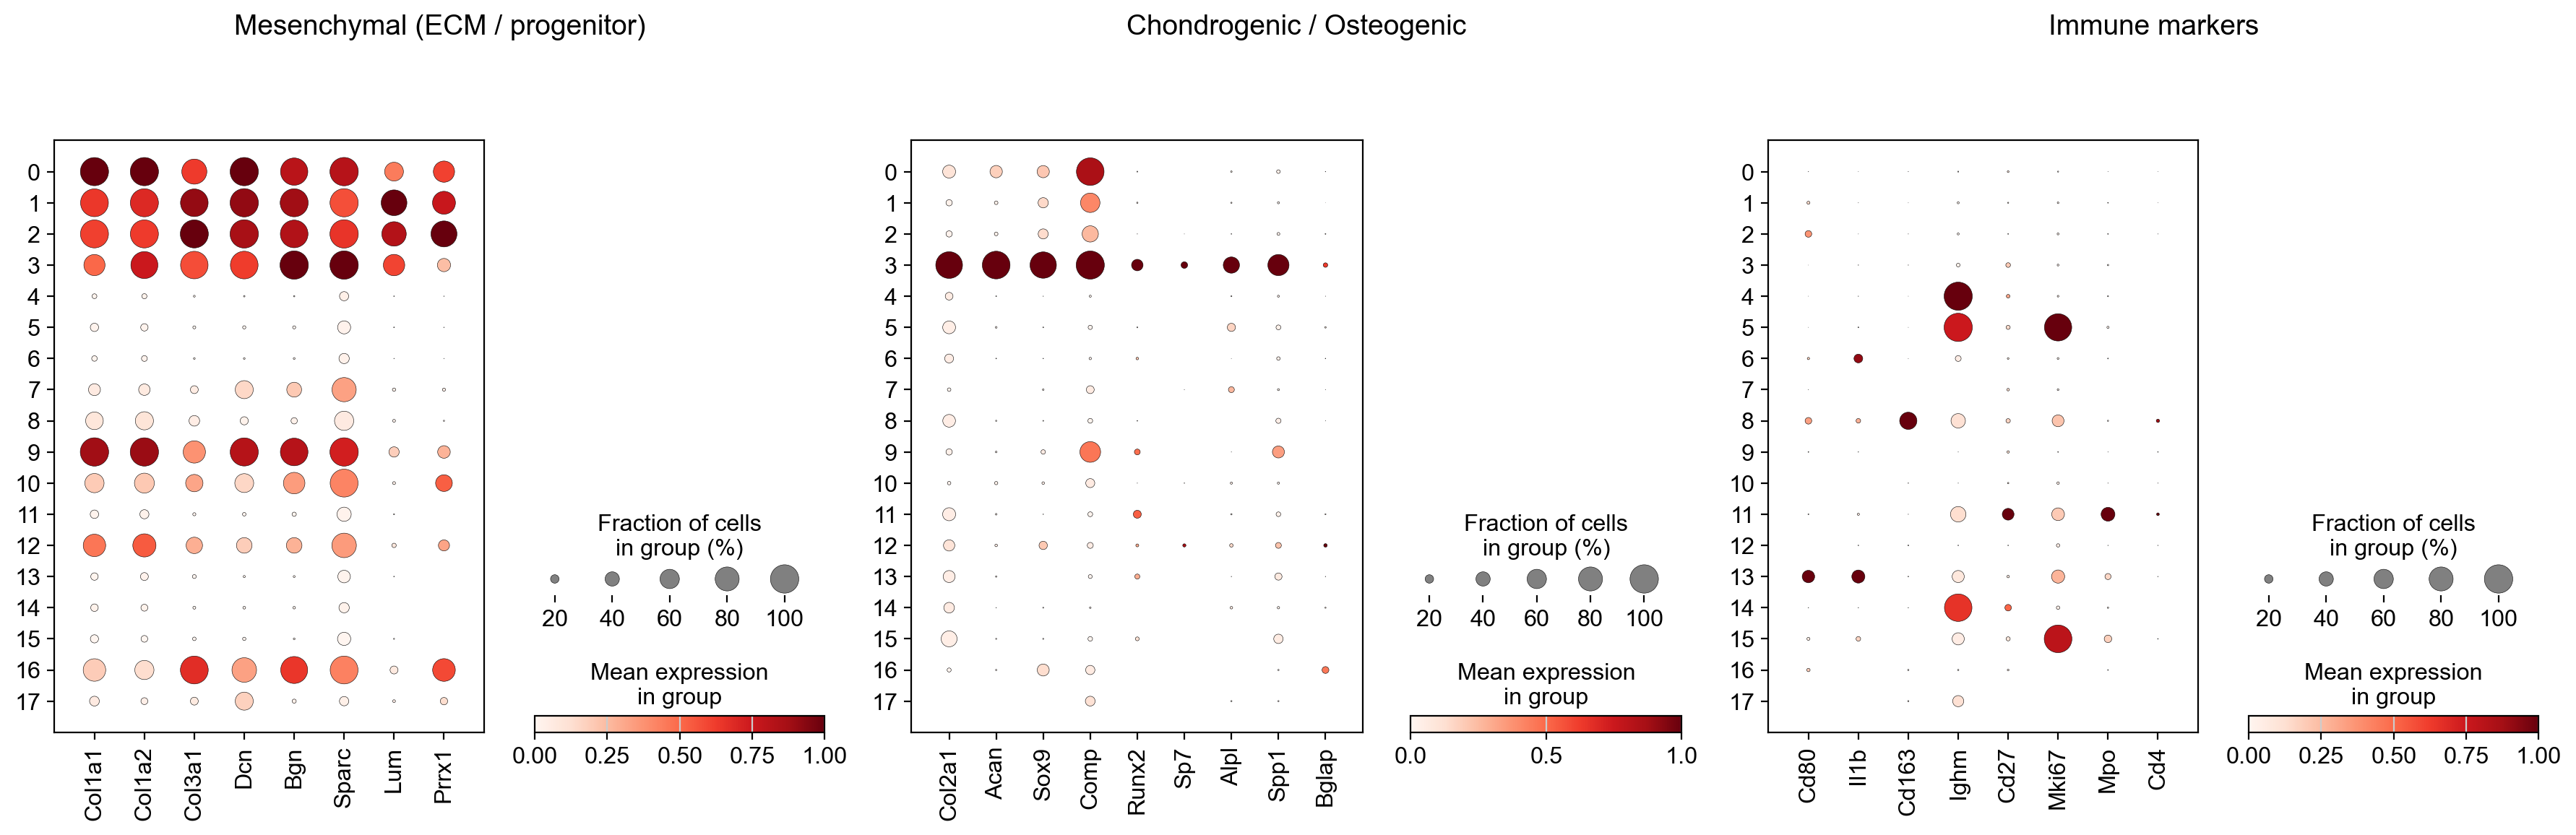

In [ ]:
# Quick meso/immune marker genes
meso_core = ["Col1a1","Col1a2","Col3a1","Dcn","Bgn","Sparc","Lum","Prrx1"]
chondro_osteo = ["Col2a1","Acan","Sox9","Comp","Runx2","Sp7","Alpl","Spp1","Bglap"]
immune = [
    # macrophage / polarization
    "Cd80","Il1b","Cd163",
    # B cells / B1 / proliferating B1
    "Cd19","Ighm","Ighd","Cd27","Mki67",
    # neutrophils
    "Mpo","Elane","Cd177","Ltf",
    # T cells
    "Cd69","Cd3g","Cd8a","Cd4"
]

immune = [g for g in immune if g in adata.var_names]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sc.pl.dotplot(
    adata,
    meso_core,
    groupby="leiden_post",
    standard_scale="var",
    ax=axes[0],
    show=False
)
axes[0].set_title("Mesenchymal (ECM / progenitor)")

sc.pl.dotplot(
    adata,
    chondro_osteo,
    groupby="leiden_post",
    standard_scale="var",
    ax=axes[1],
    show=False
)
axes[1].set_title("Chondrogenic / Osteogenic")

sc.pl.dotplot(
    adata,
    immune,
    groupby="leiden_post",
    standard_scale="var",
    ax=axes[2],
    show=False
)
axes[2].set_title("Immune markers")

plt.tight_layout()
plt.show()


extracting highly variable genes


/usr/local/Caskroom/mambaforge/base/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/1g/tyfpzm995b16hq8pjlm5m3700000gq/T/ipykernel_37599/2966540200.py:3: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  sc.pp.highly_variable_genes(adata_meso, n_top_genes=3000, flavor="seurat_v3")


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... be careful when using `max_value` without `zero_center`.
computing PCA
    with n_comps=50


/usr/local/Caskroom/mambaforge/base/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:02)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)
running Leiden clustering


/var/folders/1g/tyfpzm995b16hq8pjlm5m3700000gq/T/ipykernel_37599/2966540200.py:12: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata_meso_hvg, resolution=0.5, key_added="leiden_meso")


    finished: found 13 clusters and added
    'leiden_meso', the cluster labels (adata.obs, categorical) (0:00:01)


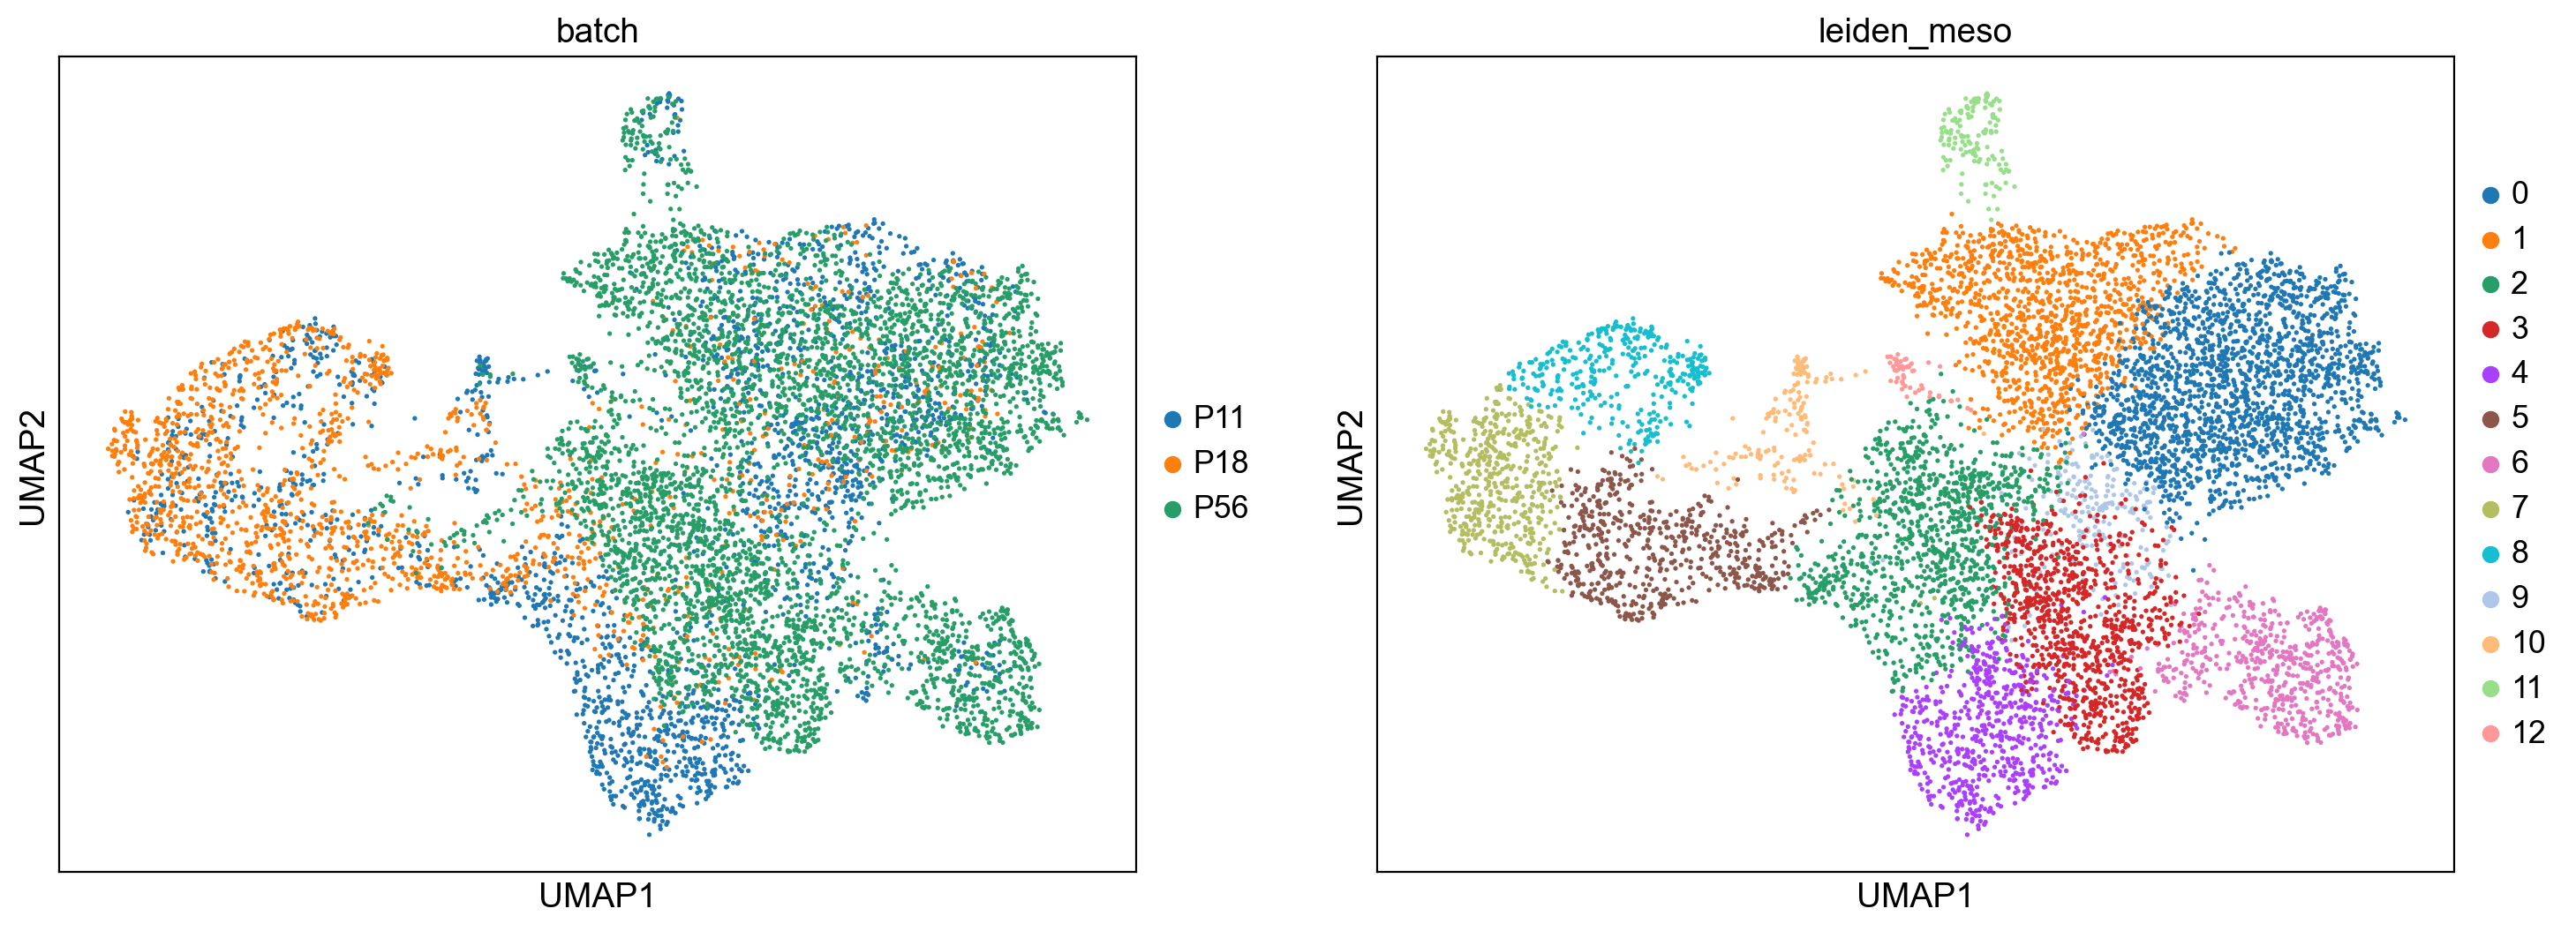

In [ ]:
#Manual cluster
meso_clusters = ["0","1","2","3","9","16"]
adata_meso = adata[adata.obs["leiden_post"].isin(meso_clusters)].copy()
sc.pp.highly_variable_genes(adata_meso, n_top_genes=3000, flavor="seurat_v3")
adata_meso_hvg = adata_meso[:, adata_meso.var.highly_variable].copy()

sc.pp.scale(adata_meso_hvg, max_value=10, zero_center=False)
sc.tl.pca(adata_meso_hvg, n_comps=50)

bbknn.bbknn(adata_meso_hvg, batch_key="batch", n_pcs=50, neighbors_within_batch=5)

sc.tl.umap(adata_meso_hvg)
sc.tl.leiden(adata_meso_hvg, resolution=0.5, key_added="leiden_meso")

sc.pl.umap(adata_meso_hvg, color=["batch", "leiden_meso"])


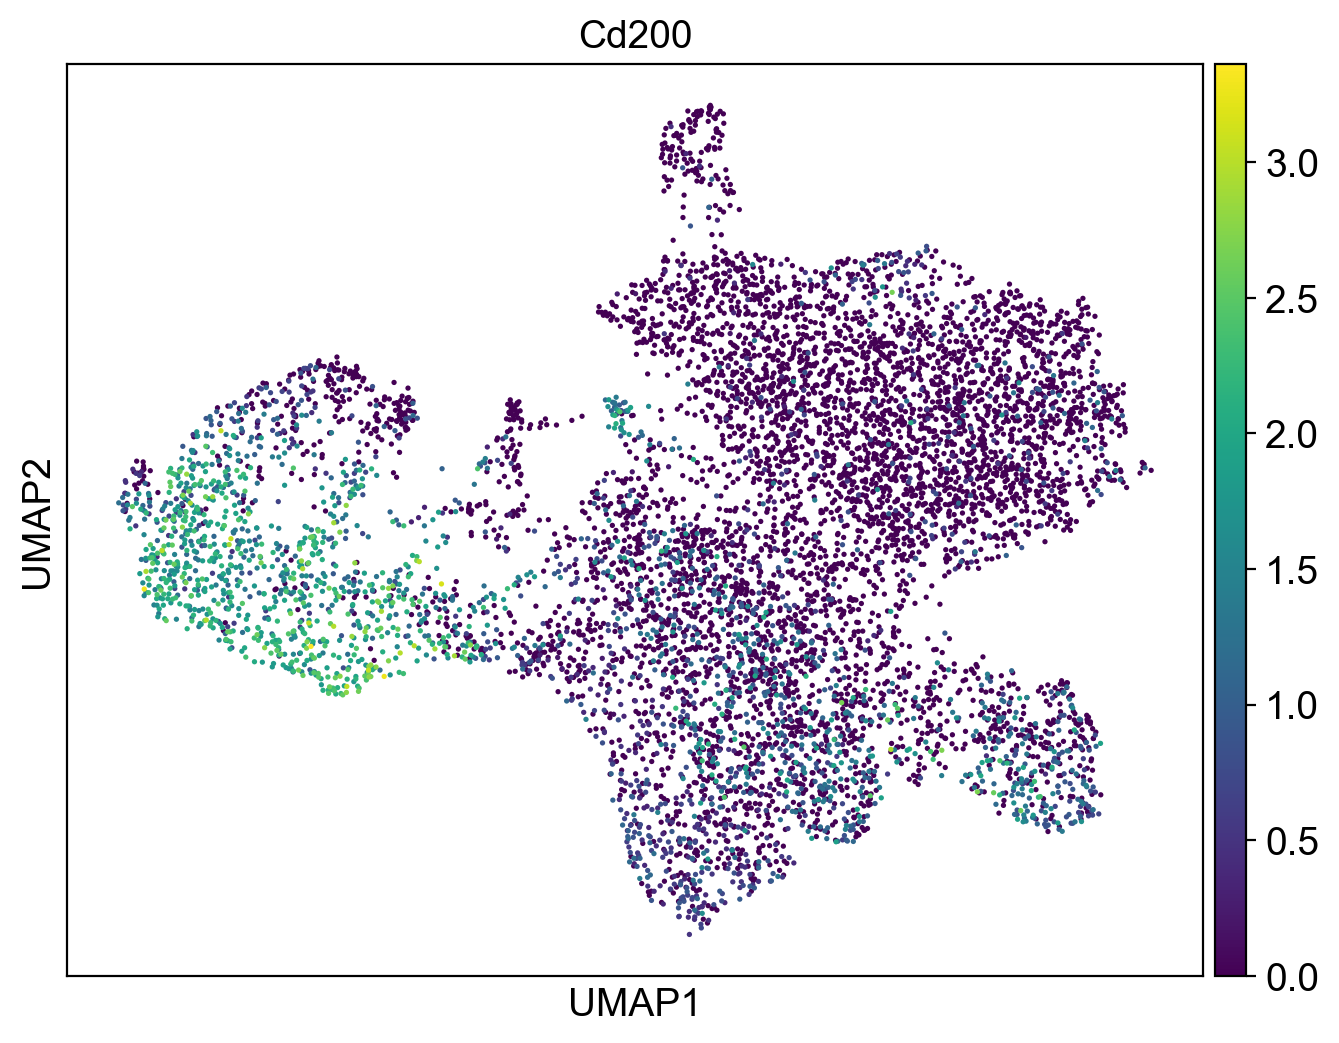

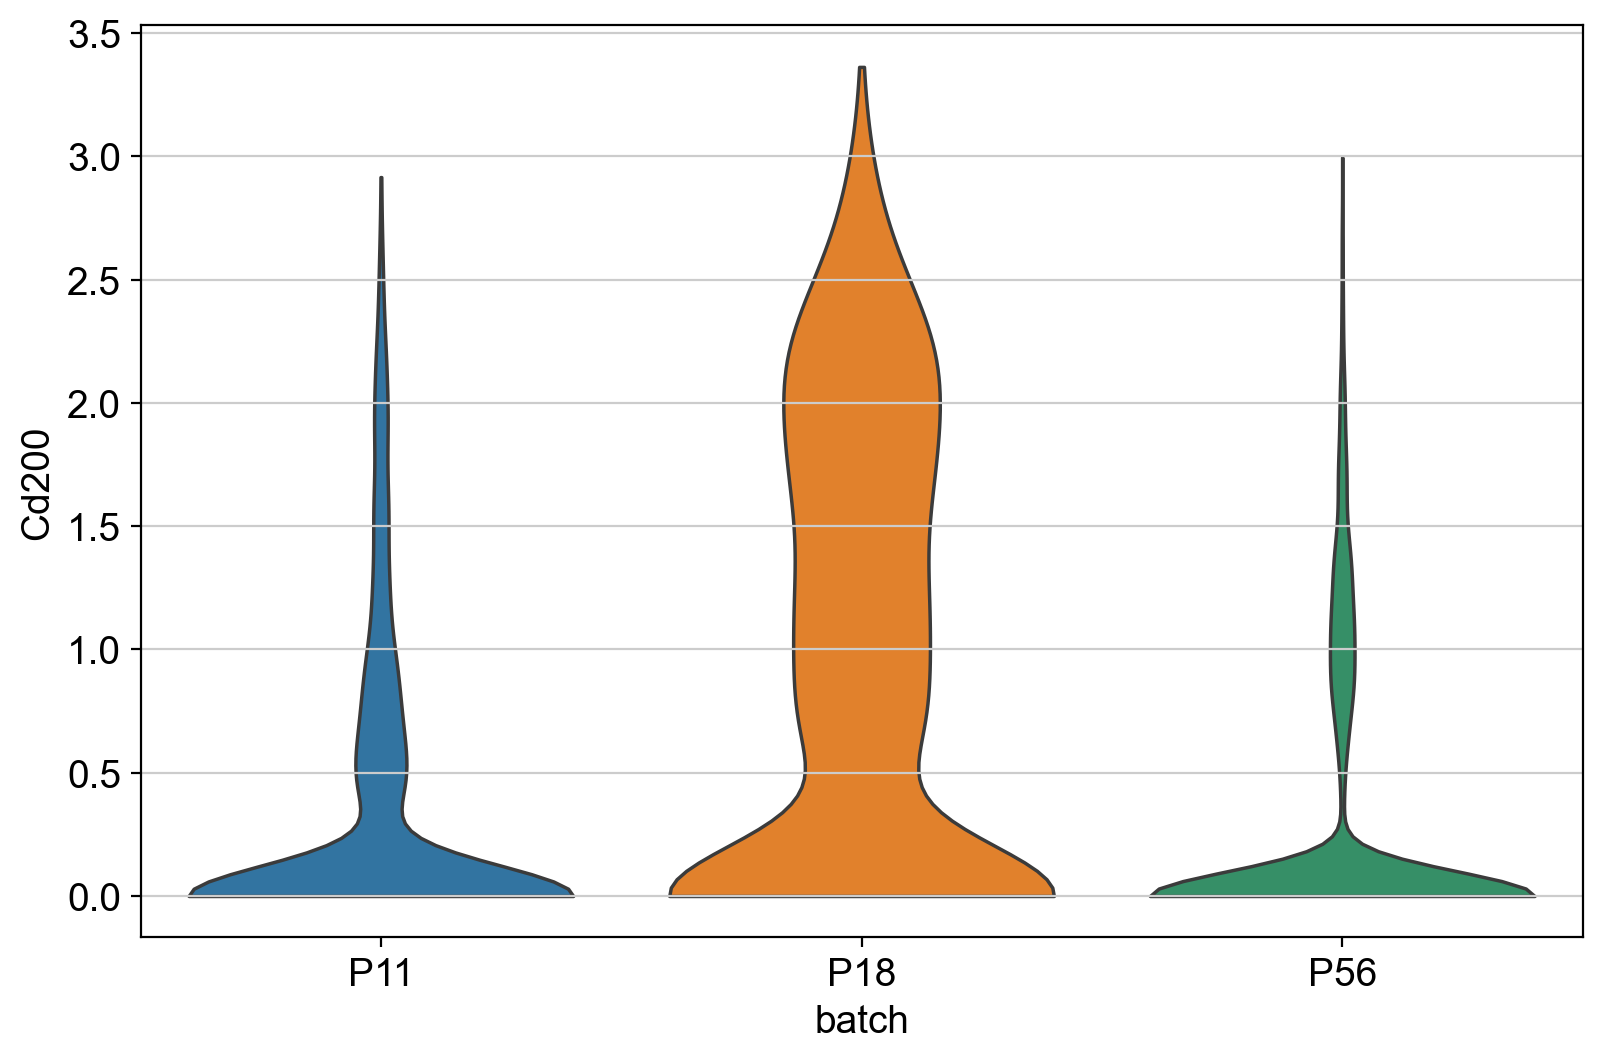

In [17]:
sc.pl.umap(adata_meso_hvg, color="Cd200")
sc.pl.violin(adata_meso_hvg, keys="Cd200", groupby="batch", stripplot=False)
